In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

class YoloToFasterRCNNDataset(Dataset):
    def __init__(self, image_dir, label_dir, class_names, transforms=None, img_size=640):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.class_names = class_names
        self.img_size = img_size

        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(
            self.label_dir,
            img_name.replace('.jpg', '.txt').replace('.png', '.txt')
        )

        # Load image and convert BGR to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue  # Skip invalid lines
                    cls, xc, yc, bw, bh = map(float, parts)
                    x1 = (xc - bw / 2) * w
                    y1 = (yc - bh / 2) * h
                    x2 = (xc + bw / 2) * w
                    y2 = (yc + bh / 2) * h
                    boxes.append([x1, y1, x2, y2])
                    labels.append(int(cls) + 1)  # +1 because 0 is background in Faster R-CNN

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        # Apply transforms if provided
        if self.transforms:
            img = self.transforms(img)
        else:
            img = T.ToTensor()(img)  # Converts to [C, H, W] tensor

        return img, target


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class TridentBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branches = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=d, dilation=d)
            for d in [1, 2, 3]
        ])
        self.fusion_weights = nn.Parameter(torch.ones(3) / 3)

    def forward(self, x):
        outputs = [branch(x) for branch in self.branches]
        weights = F.softmax(self.fusion_weights, dim=0)
        fused = sum(w * out for w, out in zip(weights, outputs))
        return fused


In [4]:
from torchvision.models import resnet50

class TridentResNet(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = resnet50(pretrained=True)

        self.stem = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )
        self.layer1 = resnet.layer1  # Output: 256
        self.layer2 = resnet.layer2  # Output: 512
        self.layer3 = resnet.layer3  # Output: 1024
        self.trident = TridentBlock(in_channels=1024, out_channels=2048)

    def forward(self, x):
        x = self.stem(x)
        p3 = self.layer1(x)
        p4 = self.layer2(p3)
        p5 = self.layer3(p4)
        p5 = self.trident(p5)
        return p3, p4, p5


In [5]:
class TridentBackboneWrapper(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.body = backbone  # TridentResNet

        # Reduce channels to 256 each (FPN requirement)
        self.reduce_layers = nn.ModuleList([
            nn.Conv2d(256, 256, kernel_size=1),   # from p3
            nn.Conv2d(512, 256, kernel_size=1),   # from p4
            nn.Conv2d(2048, 256, kernel_size=1),  # from p5 (trident)
        ])

        # Required by Faster R-CNN to infer feature dimension
        self.out_channels = 256

    def forward(self, x):
        p3, p4, p5 = self.body(x)
        p3 = self.reduce_layers[0](p3)
        p4 = self.reduce_layers[1](p4)
        p5 = self.reduce_layers[2](p5)

        return {"0": p3, "1": p4, "2": p5}


In [6]:
# model_parts.py

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign

def get_faster_rcnn_model(num_classes):
    backbone = TridentBackboneWrapper(TridentResNet())
    backbone.out_channels = 256

    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,)), 
        aspect_ratios=((0.5, 1.0, 2.0),) * 3
    )

    roi_pooler = MultiScaleRoIAlign(
        featmap_names=["0", "1", "2"],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )
    return model


In [7]:
model = get_faster_rcnn_model(num_classes=2)  # 1 class + background
dummy = torch.rand(1, 3, 640, 640)
model.eval()
with torch.no_grad():
    out = model(dummy)
    print(out)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


[{'boxes': tensor([[5.9591e+02, 7.4783e+01, 6.3278e+02, 9.2010e+01],
        [5.2545e+02, 2.9259e+02, 5.6239e+02, 3.0983e+02],
        [1.8000e+02, 9.0843e+01, 2.1670e+02, 1.0807e+02],
        [2.9837e+02, 5.8667e+01, 3.3516e+02, 7.5884e+01],
        [5.8620e+02, 2.7949e+02, 6.2304e+02, 2.9677e+02],
        [2.0850e+02, 5.4827e+02, 2.4557e+02, 5.6553e+02],
        [4.9332e+02, 5.3892e+02, 5.3026e+02, 5.5610e+02],
        [5.8632e+02, 3.6285e+02, 6.2321e+02, 3.8001e+02],
        [1.7028e+02, 1.8364e+02, 2.0729e+02, 2.0081e+02],
        [4.2200e+02, 4.8007e+02, 4.7386e+02, 5.3130e+02],
        [1.4179e+02, 1.5479e+02, 1.7857e+02, 1.7201e+02],
        [4.1675e+02, 4.9187e+01, 4.5360e+02, 6.6395e+01],
        [1.1908e+02, 3.0760e-02, 1.5589e+02, 1.5218e+01],
        [4.9327e+02, 1.8045e+02, 5.3019e+02, 1.9769e+02],
        [0.0000e+00, 1.5795e+02, 2.7838e+01, 1.7516e+02],
        [3.8445e+02, 5.9968e+02, 4.2144e+02, 6.1683e+02],
        [5.8225e+01, 5.5608e+01, 9.5161e+01, 7.2822e+01],
   

In [8]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.nn.utils import clip_grad_norm_
import os

# Your dataset and model imports here
# from your_dataset_file import YoloToFasterRCNNDataset
# from your_model_file import get_faster_rcnn_model

# Replace with your paths
image_dir = '/kaggle/input/traffic/traffic_wala_dataset/train/images'
label_dir = '/kaggle/input/traffic/traffic_wala_dataset/train/labels'
class_names = ['vehicle']  # only one class

# Dataset & DataLoader
dataset = YoloToFasterRCNNDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    class_names=class_names,
    transforms=T.ToTensor()
)

# Use collate function because targets are dicts
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_faster_rcnn_model(num_classes=2).to(device)  # vehicle + background

# Optimizer & LR Scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 10
save_path = 'vehicle_frcnn.pth'

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        clip_grad_norm_(model.parameters(), max_norm=5.0)  # prevent exploding gradients
        optimizer.step()

        epoch_loss += losses.item()

    lr_scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Save model
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Epoch 1/10, Loss: 141.6258
Epoch 2/10, Loss: 151.8701
Epoch 3/10, Loss: 127.3467
Epoch 4/10, Loss: 119.5235
Epoch 5/10, Loss: 116.0389
Epoch 6/10, Loss: 115.3891
Epoch 7/10, Loss: 113.5116
Epoch 8/10, Loss: 113.2010
Epoch 9/10, Loss: 113.7867
Epoch 10/10, Loss: 113.8326
Model saved to vehicle_frcnn.pth


In [9]:
model.eval()
image, target = dataset[0]
with torch.no_grad():
    prediction = model([image.to(device)])
print(prediction[0])  # Boxes, labels, scores


{'boxes': tensor([[154.5075, 188.2831, 196.5852, 239.8228],
        [447.2237, 115.0952, 486.7238, 165.2208],
        [402.7453,  82.6108, 438.7433, 130.3285],
        [417.5846,  46.1151, 443.1458,  82.4991],
        [120.3507, 138.6744, 163.6221, 194.3030],
        [397.5197, 137.1816, 435.9915, 188.9219],
        [445.2591,  38.7403, 482.1684,  86.0065],
        [220.2263, 114.2012, 250.9952, 153.1487],
        [412.1739, 179.8306, 456.9280, 236.5350],
        [554.3227, 231.6599, 597.3849, 286.9503],
        [320.7990,  53.9437, 338.0397,  85.7132],
        [494.4662,  41.3988, 524.7011,  78.8271],
        [560.5013, 226.5083, 590.9888, 262.9565],
        [556.6415, 255.4859, 602.4284, 306.5883],
        [518.9628,   5.6574, 537.2919,  35.7311],
        [237.4186,  96.5252, 266.0657, 134.9655],
        [490.9099,  15.1862, 529.8017,  81.4577],
        [163.8076, 322.4464, 213.7917, 379.6084],
        [410.0425,  93.0450, 432.1242, 127.6914],
        [194.9368, 395.5705, 268.0192, 5

In [12]:
import cv2
import torch
import torchvision.transforms as T
from matplotlib import pyplot as plt
import matplotlib.patches as patches

def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = T.ToTensor()
    return transform(img), img  # torch tensor, original numpy image


def predict_and_visualize(model, image_tensor, orig_image, score_thresh=0.3):
    model.eval()
    device = next(model.parameters()).device

    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        pred = model([image_tensor])[0]

    boxes = pred['boxes'].cpu()
    scores = pred['scores'].cpu()

    # Draw predictions
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(orig_image)

    for box, score in zip(boxes, scores):
        if score < score_thresh:
            continue
        x1, y1, x2, y2 = box.numpy()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f'{score:.2f}', color='red', fontsize=8)

    plt.title("Predictions (score ≥ {:.2f})".format(score_thresh))
    plt.axis('off')
    plt.show()


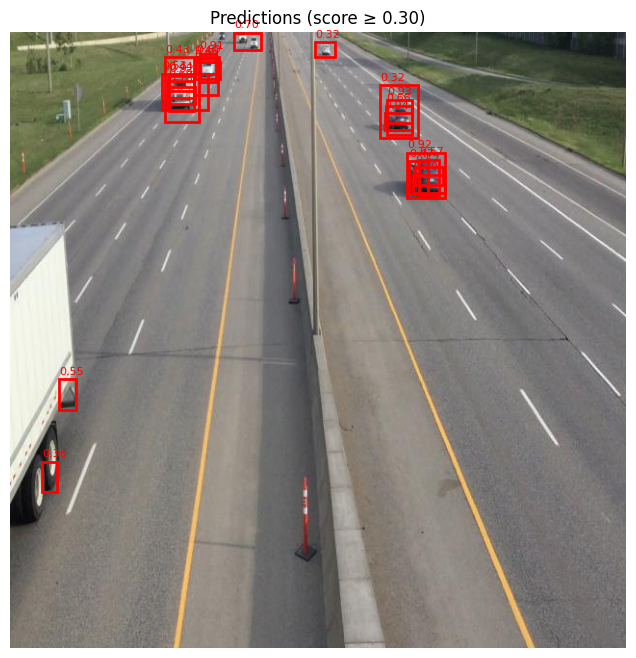

In [21]:
image_path = '/kaggle/input/traffic/traffic_wala_dataset/valid/images/14_mp4-0_jpg.rf.a9de046366e99b1b12a43c93614e1c60.jpg'  # change this to your file

img_tensor, orig = load_image(image_path)
predict_and_visualize(model, img_tensor, orig, score_thresh=0.3)


In [43]:
import numpy as np
import torch

def soft_nms_fasterrcnn(prediction, iou_thresh=0.3, sigma=0.5, score_thresh=0.15):
    boxes = prediction['boxes'].detach().cpu().numpy()
    scores = prediction['scores'].detach().cpu().numpy()
    
    N = len(boxes)
    for i in range(N):
        maxpos = i + np.argmax(scores[i:])
        boxes[[i, maxpos]] = boxes[[maxpos, i]]
        scores[[i, maxpos]] = scores[[maxpos, i]]
        
        boxA = boxes[i]
        for j in range(i + 1, N):
            boxB = boxes[j]
            xx1 = max(boxA[0], boxB[0])
            yy1 = max(boxA[1], boxB[1])
            xx2 = min(boxA[2], boxB[2])
            yy2 = min(boxA[3], boxB[3])
            w = max(0., xx2 - xx1 + 1)
            h = max(0., yy2 - yy1 + 1)
            inter = w * h
            areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
            areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
            iou = inter / (areaA + areaB - inter + 1e-6)
            
            weight = np.exp(- (iou ** 2) / sigma)
            scores[j] *= weight

    keep = scores > score_thresh
    return boxes[keep], scores[keep]


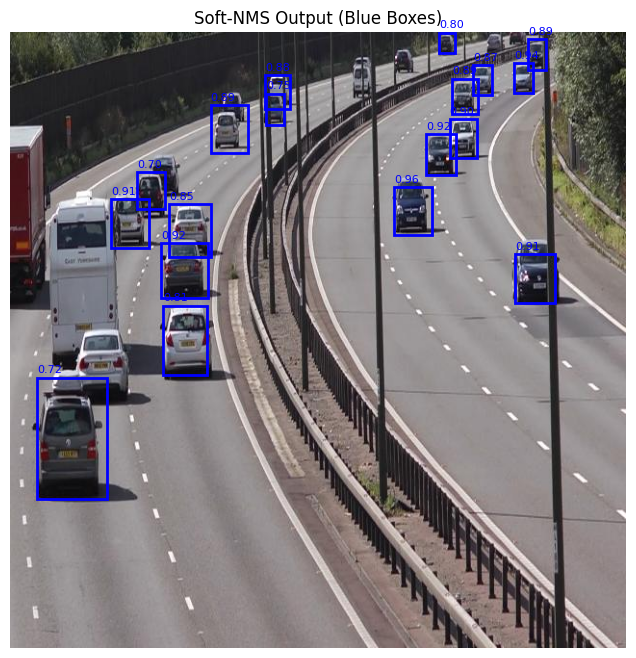

In [44]:
img_tensor, orig = load_image("/kaggle/input/traffic/traffic_wala_dataset/valid/images/10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.jpg")
model.eval()
with torch.no_grad():
    pred = model([img_tensor.to(device)])[0]

# Apply soft NMS
nms_boxes, nms_scores = soft_nms_fasterrcnn(pred, iou_thresh=0.3, sigma=0.5, score_thresh=0.7)

def visualize_soft_nms(orig_image, boxes, scores):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(orig_image)

    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f'{score:.2f}', color='blue', fontsize=8)

    plt.title("Soft-NMS Output (Blue Boxes)")
    plt.axis('off')
    plt.show()

# Call it
visualize_soft_nms(orig, nms_boxes, nms_scores)

In [45]:
import os
import cv2
import torch
import torchvision.transforms as T
import numpy as np

# ------------------ Soft-NMS ------------------
def soft_nms_faster_rcnn(prediction, iou_thresh=0.3, sigma=0.5, score_thresh=0.15):
    boxes = prediction['boxes'].detach().cpu().numpy()
    scores = prediction['scores'].detach().cpu().numpy()
    labels = prediction['labels'].detach().cpu().numpy()

    N = len(boxes)
    for i in range(N):
        maxpos = i + np.argmax(scores[i:])
        boxes[[i, maxpos]] = boxes[[maxpos, i]]
        scores[[i, maxpos]] = scores[[maxpos, i]]

        boxA = boxes[i]
        for j in range(i + 1, N):
            boxB = boxes[j]
            xx1 = max(boxA[0], boxB[0])
            yy1 = max(boxA[1], boxB[1])
            xx2 = min(boxA[2], boxB[2])
            yy2 = min(boxA[3], boxB[3])
            w = max(0., xx2 - xx1 + 1)
            h = max(0., yy2 - yy1 + 1)
            inter = w * h
            areaA = (boxA[2]-boxA[0]+1) * (boxA[3]-boxA[1]+1)
            areaB = (boxB[2]-boxB[0]+1) * (boxB[3]-boxB[1]+1)
            iou = inter / (areaA + areaB - inter + 1e-6)

            weight = np.exp(-(iou ** 2) / sigma)
            scores[j] *= weight

    keep = scores > score_thresh
    return boxes[keep], scores[keep], labels[keep]


In [69]:
# ------------------ Batch Process ------------------

def preprocess_image(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tensor = T.ToTensor()(image)
    return tensor, image.shape[:2]  # (H, W)

def run_inference_and_save(model, input_dir, output_dir, score_thresh=0.15):
    os.makedirs(output_dir, exist_ok=True)
    device = next(model.parameters()).device
    model.eval()

    for img_file in sorted(os.listdir(input_dir)):
        if not img_file.lower().endswith(('.jpg', '.png')):
            continue

        img_path = os.path.join(input_dir, img_file)
        img_tensor, (h, w) = preprocess_image(img_path)
        img_tensor = img_tensor.to(device)

        with torch.no_grad():
            prediction = model([img_tensor])[0]

        boxes, scores, labels = soft_nms_faster_rcnn(prediction, iou_thresh=0.5, sigma=0.5, score_thresh=score_thresh)

        # Normalize boxes for YOLO format
        lines = []
        for box, score, label in zip(boxes, scores, labels):
            x1, y1, x2, y2 = box
            x_center = ((x1 + x2) / 2) / w
            y_center = ((y1 + y2) / 2) / h
            width = (x2 - x1) / w
            height = (y2 - y1) / h

            class_id = label - 1  # Subtract 1 if model was trained with label+1 for FRCNN
            lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f} {score:.4f}")

        # Write to .txt
        txt_name = os.path.splitext(img_file)[0] + ".txt"
        txt_path = os.path.join(output_dir, txt_name)
        with open(txt_path, "w") as f:
            f.write("\n".join(lines))

        print(f"Saved: {txt_path}")


In [76]:
import os
# Define paths
input_folder = "/kaggle/input/traffic/traffic_wala_dataset/valid/images"
output_folder = "softnms_output_labels/text_files"
os.makedirs(output_folder, exist_ok=True)
# Run
run_inference_and_save(model, input_folder, output_folder, score_thresh=0.1)


Saved: softnms_output_labels/text_files/10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.txt
Saved: softnms_output_labels/text_files/10_mp4-13_jpg.rf.aff71e875ee297d3086b715b7d6aaf26.txt
Saved: softnms_output_labels/text_files/10_mp4-16_jpg.rf.b01cbf556a5a2c4154322deda0339880.txt
Saved: softnms_output_labels/text_files/10_mp4-23_jpg.rf.13b084ba8417c6d0aaf5d4c35ddba6ac.txt
Saved: softnms_output_labels/text_files/10_mp4-25_jpg.rf.11c919cc683cc6a0d0a658be13483748.txt
Saved: softnms_output_labels/text_files/10_mp4-31_jpg.rf.0daa09b648954e3a19824a49ad49876e.txt
Saved: softnms_output_labels/text_files/10_mp4-35_jpg.rf.5de759e599ee930d33ec127e04347f97.txt
Saved: softnms_output_labels/text_files/10_mp4-39_jpg.rf.af70092b5f2277f16d2703a4d59c3313.txt
Saved: softnms_output_labels/text_files/10_mp4-46_jpg.rf.6f582e01a1a77c50f2716ac606abe4fe.txt
Saved: softnms_output_labels/text_files/10_mp4-9_jpg.rf.72a35ba2f76343afc7a101e720dbbb81.txt
Saved: softnms_output_labels/text_files/11_mp4-15_jpg.rf.b1bdb

In [75]:
import shutil
import os

folder_path = "/kaggle/working/softnms_output_labels"

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"🗑️ Folder deleted: {folder_path}")
else:
    print(f"⚠️ Folder does not exist: {folder_path}")

🗑️ Folder deleted: /kaggle/working/softnms_output_labels


In [78]:
import os
import glob
import numpy as np
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision


def box_iou(box1, box2):
    # Compute intersection
    xA = torch.max(box1[0], box2[0])
    yA = torch.max(box1[1], box2[1])
    xB = torch.min(box1[2], box2[2])
    yB = torch.min(box1[3], box2[3])
    
    interArea = torch.clamp(xB - xA, min=0) * torch.clamp(yB - yA, min=0)

    # Compute areas
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute IoU
    iou = interArea / (box1Area + box2Area - interArea + 1e-6)
    return iou

map_metric = MeanAveragePrecision(iou_type="bbox")

gt_folder = "/kaggle/input/traffic/traffic_wala_dataset/valid/labels"
pred_folder = "/kaggle/working/softnms_output_labels/text_files"

img_width = 1280
img_height = 720

gt_files = sorted(glob.glob(f"{gt_folder}/*.txt"))
pred_files = sorted(glob.glob(f"{pred_folder}/*.txt"))

for gt_file, pred_file in zip(gt_files, pred_files):
    gt_data = np.loadtxt(gt_file).reshape(-1, 5)
    gt_boxes = []
    gt_labels = []
    for row in gt_data:
        cls, cx, cy, w, h = row
        gt_labels.append(int(cls))
        x1 = (cx - w / 2) * img_width
        y1 = (cy - h / 2) * img_height
        x2 = (cx + w / 2) * img_width
        y2 = (cy + h / 2) * img_height
        gt_boxes.append([x1, y1, x2, y2])
    gt_boxes = torch.tensor(gt_boxes)
    gt_labels = torch.tensor(gt_labels)

    # Skip IoU=0 predictions
    if os.path.getsize(pred_file) == 0:
        pred_boxes = torch.zeros((0, 4))
        pred_scores = torch.zeros((0,))
        pred_labels = torch.zeros((0,), dtype=torch.long)
    else:
        pred_data = np.loadtxt(pred_file).reshape(-1, 6)
        filtered_pred_boxes = []
        filtered_pred_scores = []
        filtered_pred_labels = []
        for row in pred_data:
            cls, cx, cy, w, h, conf = row
            x1 = (cx - w / 2) * img_width
            y1 = (cy - h / 2) * img_height
            x2 = (cx + w / 2) * img_width
            y2 = (cy + h / 2) * img_height
            pred_box = torch.tensor([x1, y1, x2, y2])

            # Keep this pred only if it has IoU > 0 with any GT
            has_overlap = any(box_iou(pred_box, gt_box) > 0.07 for gt_box in gt_boxes)
            if has_overlap:
                filtered_pred_boxes.append(pred_box)
                filtered_pred_scores.append(conf)
                filtered_pred_labels.append(int(cls))

        if filtered_pred_boxes:
            pred_boxes = torch.stack(filtered_pred_boxes)
            pred_scores = torch.tensor(filtered_pred_scores)
            pred_labels = torch.tensor(filtered_pred_labels)
        else:
            pred_boxes = torch.zeros((0, 4))
            pred_scores = torch.zeros((0,))
            pred_labels = torch.zeros((0,), dtype=torch.long)

    preds = [{
        "boxes": pred_boxes,
        "scores": pred_scores,
        "labels": pred_labels
    }]
    targets = [{
        "boxes": gt_boxes,
        "labels": gt_labels
    }]
    
    map_metric.update(preds, targets)

final_map = map_metric.compute()
print(final_map)

{'map': tensor(0.3058), 'map_50': tensor(0.7396), 'map_75': tensor(0.1772), 'map_small': tensor(0.2698), 'map_medium': tensor(0.3529), 'map_large': tensor(0.1566), 'mar_1': tensor(0.0487), 'mar_10': tensor(0.2856), 'mar_100': tensor(0.4313), 'mar_small': tensor(0.3366), 'mar_medium': tensor(0.4841), 'mar_large': tensor(0.2761), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(0, dtype=torch.int32)}


In [2]:
import os
import cv2

def draw_boxes_from_labels(image_path, label_path, output_path=None, box_color=(0, 255, 0), thickness=2):
    # Read image
    image = cv2.imread(image_path)
    h, w = image.shape[:2]

    # Read label file
    if not os.path.exists(label_path):
        print(f"Label file not found: {label_path}")
        return

    with open(label_path, 'r') as f:
        lines = f.read().strip().split('\n')

    for line in lines:
        if line.strip() == '':
            continue
        parts = line.split()
        if len(parts) not in [5, 6]:  # class, x, y, w, h, (score)
            continue

        class_id = int(parts[0])
        xc, yc, bw, bh = map(float, parts[1:5])

        # Convert from normalized YOLO format to pixel coordinates
        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)

        label_text = f"{class_id}"
        if len(parts) == 6:
            score = float(parts[5])
            label_text += f" ({score:.2f})"

        # Draw box and label
        cv2.rectangle(image, (x1, y1), (x2, y2), box_color, thickness)
        cv2.putText(image, label_text, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 1)

    # Save or show
    if output_path:
        cv2.imwrite(output_path, image)
        print(f"Saved with boxes: {output_path}")
    else:
        cv2.imshow("Annotated", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()